_Importing Required Libraries_

In [1]:
pip install hampel

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\Anurag Dutta\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import keras
import tensorflow as tf
from hampel import hampel
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from matplotlib import pyplot
from numpy import array

## Pretraining

The `capa_intermittency.dat` feeds the model with the dynamics of the Capacitor

In [3]:
data = np.genfromtxt('capa_intermittency.dat')
training_set = pd.DataFrame(data).reset_index(drop=True)
training_set = training_set.iloc[:,0]

## Computing the Gradient

_Calculating the value of_ $\frac{dx}{dt}$

In [4]:
t_diff = 1
print(training_set.max())
gradient_t = (training_set.diff()/t_diff).iloc[1:] # dx/dt
print(gradient_t)

1.0
1        0.000298
2        0.000298
3        0.000297
4        0.000297
5        0.000297
           ...   
9996     0.000018
9997     0.000018
9998     0.000018
9999     0.000018
10000    0.000018
Name: 0, Length: 10000, dtype: float64


## Loading Datasets

In [5]:
data = pd.read_csv("c6_interpolated_2000_100.csv")
training_set = data.iloc[:, 1]
training_set

0       84.600000
1       84.431933
2       84.263866
3       84.095798
4       83.927731
          ...    
2095    49.315488
2096    49.301949
2097    49.288410
2098    49.274872
2099    49.261333
Name: C6, Length: 2100, dtype: float64

In [6]:
test = training_set.tail(100)
test
training_set = training_set.head(2000)
training_set

0       84.600000
1       84.431933
2       84.263866
3       84.095798
4       83.927731
          ...    
1995     0.137562
1996     0.042930
1997     0.648720
1998     0.536104
1999     0.107818
Name: C6, Length: 2000, dtype: float64

In [7]:
training_set = training_set.reset_index(drop=True)
gradient_t = gradient_t.reset_index(drop=True)
print(gradient_t)

0       0.000298
1       0.000298
2       0.000297
3       0.000297
4       0.000297
          ...   
9995    0.000018
9996    0.000018
9997    0.000018
9998    0.000018
9999    0.000018
Name: 0, Length: 10000, dtype: float64


In [8]:
df = pd.concat((training_set, gradient_t), axis=1)
df.columns = ['y_t', 'grad_t']

In [9]:
df

,y_t,grad_t
0,84.600000,0.000298
1,84.431933,0.000298
2,84.263866,0.000297
3,84.095798,0.000297
4,83.927731,0.000297
...,...,...
9995,NaN,0.000018
9996,NaN,0.000018
9997,NaN,0.000018
9998,NaN,0.000018


## Plot of the External Forcing from Chaotic Differential Equation

<Axes: >

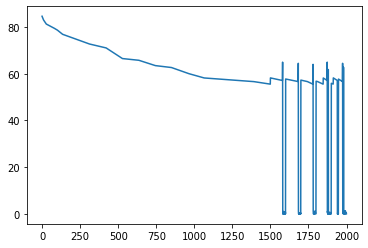

In [10]:
df.iloc[:, 0].plot()

C:\Users\Anurag Dutta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: >

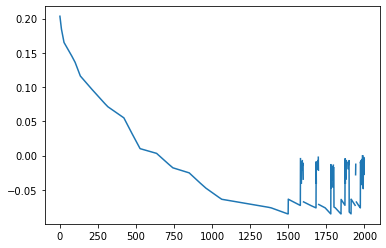

In [11]:
import numpy as np
c0 = 82.7524  # Value for C0
K0 = -0.0031  # Value for K0
K1 = -0.0003  # Value for K1
a = 0.0000    # Value for a
b = 0.0171    # Value for b
c = 3.0230    # Value for c

L = np.minimum(c0, (df.iloc[:, 1] - (df.iloc[:, 0] * (K0 - K1 * (9 * a * np.log(df.iloc[:, 0] / c0) / (K0 - K1 * c)**2 + 4 * b * np.log(df.iloc[:, 0] / c0) / (K0 - K1 * c) + c)))))
L.plot()

## Preprocessing the data into supervised learning

In [12]:
# split a sequence into samples
def Supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n_in, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n_out)
    for i in range(0, n_out):
      cols.append(df.shift(-i))
      if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
      else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
       agg.dropna(inplace=True)
    return agg

In [13]:
data = Supervised(df.values, n_in = 350, n_out = 100)


cols_to_drop = []
for i in range(2, 351):
    cols_to_drop.extend([f'var2(t-{i})'])

data.drop(cols_to_drop, axis=1, inplace=True)

print(data.head())
print(data.columns)

     var1(t-350)  var1(t-349)  var1(t-348)  var1(t-347)  var1(t-346)  \
350    84.600000    84.431933    84.263866    84.095798    83.927731   
351    84.431933    84.263866    84.095798    83.927731    83.759664   
352    84.263866    84.095798    83.927731    83.759664    83.591597   
353    84.095798    83.927731    83.759664    83.591597    83.423529   
354    83.927731    83.759664    83.591597    83.423529    83.255462   

     var1(t-345)  var1(t-344)  var1(t-343)  var1(t-342)  var1(t-341)  ...  \
350    83.759664    83.591597    83.423529    83.255462    83.092437  ...   
351    83.591597    83.423529    83.255462    83.092437    82.991597  ...   
352    83.423529    83.255462    83.092437    82.991597    82.890756  ...   
353    83.255462    83.092437    82.991597    82.890756    82.789916  ...   
354    83.092437    82.991597    82.890756    82.789916    82.689076  ...   

     var1(t+95)  var2(t+95)  var1(t+96)  var2(t+96)  var1(t+97)  var2(t+97)  \
350   70.003688    0.0002

In [14]:
train = np.array(data[0:len(data)-1])
forecast = np.array(data.tail(1))

In [15]:
trainy = train[:,-300:]
trainX = train[:,:-300]

In [16]:
forecasty = forecast[:,-300:]
forecastX = forecast[:,:-300]

In [17]:
trainX = trainX.reshape((trainX.shape[0], 1, trainX.shape[1]))
forecastX = forecastX.reshape((forecastX.shape[0], 1, forecastX.shape[1]))
print(trainX.shape, trainy.shape, forecastX.shape)

(1550, 1, 251) (1550, 300) (1, 1, 251)


In [18]:
C0 = tf.Variable(82.7524, name="C0", trainable=True, dtype=tf.float32)
K0 = tf.Variable(-0.0031, name="K0", trainable=True, dtype=tf.float32)
K1 = tf.Variable(-0.0003, name="K1", trainable=True, dtype=tf.float32)
a = tf.Variable(0.0000, name="a", trainable=True, dtype=tf.float32)
b = tf.Variable(0.0171, name="b", trainable=True, dtype=tf.float32)
c = tf.Variable(3.0230, name="c", trainable=True, dtype=tf.float32)

splitr = 0.8


def loss_fn(y_true, y_pred):
    squared_difference = tf.square(y_true[:, 0] - y_pred[:, 0])
    #squared_difference2 = tf.square(y_true[:, 2]-y_pred[:, 2])
    #squared_difference1 = tf.square(y_true[:, 1]-y_pred[:, 1])
    epsilon = 1
    squared_difference3 = tf.square(
        y_pred[:, 1] - (
            y_pred[:, 0] * (
                K0 - K1 * (
                    9 * a * tf.math.log((y_pred[:, 0] + epsilon) / C0) / (K0 - K1 * c)**2 +
                    4 * b * tf.math.log((y_pred[:, 0] + epsilon) / C0) / (K0 - K1 * c) + c
                )
            )
        )
    )
    return tf.reduce_mean(squared_difference, axis=-1) + 0.2*tf.reduce_mean(squared_difference3, axis=-1)
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(60))
model.compile(loss=loss_fn, optimizer='adam')
history = model.fit(trainX[:int(splitr*trainX.shape[0])], trainy[:int(splitr*trainX.shape[0])], epochs=500, batch_size=64, validation_data=(trainX[int(splitr*trainX.shape[0]):trainX.shape[0]], trainy[int(splitr*trainX.shape[0]):trainX.shape[0]]), shuffle=False)

Epoch 1/500
20/20 [==============================] - 3s 30ms/step - loss: 3749.4343 - val_loss: 2499.8062
Epoch 2/500
20/20 [==============================] - 0s 4ms/step - loss: 3653.7048 - val_loss: 2449.7444
Epoch 3/500
20/20 [==============================] - 0s 5ms/step - loss: 3578.4739 - val_loss: 2395.0989
Epoch 4/500
20/20 [==============================] - 0s 4ms/step - loss: 3504.1677 - val_loss: 2346.5142
Epoch 5/500
20/20 [==============================] - 0s 5ms/step - loss: 3434.8674 - val_loss: 2299.1245
Epoch 6/500
20/20 [==============================] - 0s 4ms/step - loss: 3367.1582 - val_loss: 2252.8621
Epoch 7/500
20/20 [==============================] - 0s 4ms/step - loss: 3300.8391 - val_loss: 2207.5886
Epoch 8/500
20/20 [==============================] - 0s 6ms/step - loss: 3235.7437 - val_loss: 2163.2197
Epoch 9/500
20/20 [==============================] - 0s 6ms/step - loss: 3171.7742 - val_loss: 2119.7048
Epoch 10/500
20/20 [==============================] - 

In [19]:
forecast_without_mc = forecastX
yhat_without_mc = model.predict(forecast_without_mc) # Step Ahead Prediction
forecast_without_mc = forecast_without_mc.reshape((forecast_without_mc.shape[0], forecast_without_mc.shape[2])) # Historical Input

1/1 [==============================] - 0s 475ms/step


In [20]:
forecastX.shape

(1, 1, 251)

In [21]:
forecast_without_mc.shape

(1, 251)

In [22]:
inv_yhat_without_mc = np.concatenate((forecast_without_mc, yhat_without_mc), axis=1) # Concatenation of predicted values with Historical Data
#inv_yhat_without_mc = scaler.inverse_transform(inv_yhat_without_mc) # Transform labels back to original encoding

In [23]:
inv_yhat_without_mc.shape

(1, 311)

In [24]:
fforecast = inv_yhat_without_mc[:,-300:]

In [25]:
fforecast.shape

(1, 300)

In [26]:
final_forecast = fforecast[:,0:300:3]

In [27]:
fforecast.shape

(1, 300)

In [28]:
# code to replace all negative value with 0
final_forecast[final_forecast<0] = 0

In [29]:
final_forecast

array([[5.73506769e+01, 5.73086601e+01, 5.72666433e+01, 5.72246265e+01,
        5.71826097e+01, 5.71405929e+01, 5.70985761e+01, 0.00000000e+00,
        0.00000000e+00, 1.71529650e-01, 4.40962280e-01, 7.98189880e-01,
        2.09573240e-01, 5.77381653e+01, 5.76961485e+01, 5.76541316e+01,
        5.76121148e+01, 5.75700980e+01, 5.75280812e+01, 5.74870644e+01,
        5.74440476e+01, 5.74020308e+01, 5.73600140e+01, 5.73179972e+01,
        5.72775980e+01, 5.72353964e+01, 5.71941947e+01, 5.71599930e+01,
        5.71187913e+01, 5.70799902e+01, 5.70427885e+01, 5.70055868e+01,
        5.69683851e+01, 5.69291835e+01, 5.68919821e+01, 5.68547806e+01,
        5.68175789e+01, 5.67803771e+01, 5.67431754e+01, 5.67059737e+01,
        5.66687720e+01, 1.04408872e+00, 4.30057615e-01, 0.00000000e+00,
        1.88607156e-01, 0.00000000e+00, 0.00000000e+00, 5.72433007e+01,
        5.72012839e+01, 5.71592670e+01, 5.71172502e+01, 5.70752334e+01,
        5.70332166e+01, 5.69911998e+01, 5.69491830e+01, 5.690716

In [30]:
final_forecast.shape

(1, 100)

In [31]:
test.shape

(100,)

In [32]:
training_set = np.array(training_set)
test = np.array(test)
final_forecast = np.array(final_forecast.squeeze(0))

In [33]:
test

array([50.601669  , 50.58813025, 50.5745915 , 50.56105275, 50.54751401,
       50.53397526, 50.52043651, 50.50689776, 50.49335901, 50.47982026,
       50.46628151, 50.45274276, 50.43920401, 50.42566527, 50.41212652,
       50.39858777, 50.38504902, 50.37151027, 50.35797152, 50.34443277,
       50.33089402, 50.31735528, 50.30381653, 50.29027778, 50.27673903,
       50.26320028, 50.24966153, 50.23612278, 50.22258403, 50.20904528,
       50.19550654, 50.18196779, 50.16842904, 50.15489029, 50.14135154,
       50.12781279, 50.11427404, 50.10073529, 50.08719655, 50.0736578 ,
       50.06011905, 50.0465803 , 50.03304155, 50.0195028 , 50.00596405,
       49.9924253 , 49.97888655, 49.96534781, 49.95180906, 49.93827031,
       49.92473156, 49.91119281, 49.89765406, 49.88411531, 49.87057656,
       49.85703782, 49.84349907, 49.82996032, 49.81642157, 49.80288282,
       49.78934407, 49.77580532, 49.76226657, 49.74872782, 49.73518908,
       49.72165033, 49.70811158, 49.69457283, 49.68103408, 49.66

In [34]:
test.shape

(100,)

In [35]:
final_forecast.shape

(100,)

In [36]:
test.shape

(100,)

In [37]:
import math
MSE = np.square(np.subtract(np.array(test),np.array(final_forecast))).mean()   
rsme = math.sqrt(MSE)
print(rsme)  
MAE = np.abs(np.subtract(np.array(test),np.array(final_forecast))).mean()   
mae = MAE
print(mae)

30.56112124802635
22.599197303556437
